# Tweets Classification

In this note book we will try to classify tweets to Politics or Sports using bag of word + XGBoost as approach.



## Importing the libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing the dataset

In [4]:
train = pd.read_csv('/kaggle/input/deeptweets/train.csv')
test = pd.read_csv('/kaggle/input/deeptweets/test.csv')

In [5]:
train.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


In [6]:
train.shape

(6525, 3)

In [7]:
train.isna().sum()

TweetId      0
Label        0
TweetText    0
dtype: int64

In [8]:
class_counts = train['Label'].value_counts()
class_counts

Sports      3325
Politics    3200
Name: Label, dtype: int64

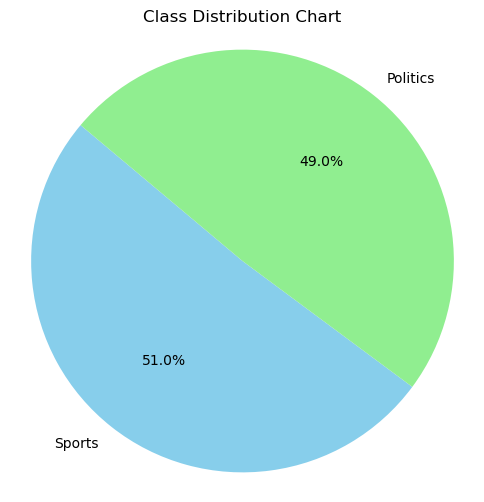

In [9]:
labels = ['Sports','Politics']

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen'])
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Set the title
plt.title('Class Distribution Chart')

# Show the plot
plt.show()


## Cleaning the texts

In this step we will remove all the non alphabetic letters (#,/,\,...) and make them all in lowercase, then delete all the stop words to reduse the bag of word vector size without removing any word that can give meaning to tthe classification

In [10]:
def cleaning(data):

  #List to put in the clean data
  clean_data = []

  for i in range(0, data.shape[0]):

    #remove all non alphabetic letters
    tweets = re.sub('[^a-zA-Z]', ' ', data['TweetText'][i])

    #all letters to lower case
    tweets = tweets.lower()

    #turn tweet to list of word
    tweets = tweets.split()

    #remove all the conjugation in the word, for example had -> have + remove the stop words
    ps = PorterStemmer()
    all_stopwords = stopwords.words('english')
    tweets = [ps.stem(word) for word in tweets if not word in set(all_stopwords)]

    #turn list of word to a tweet
    tweets = ' '.join(tweets)

    #add the tweet to the list
    clean_data.append(tweets)

  return clean_data

In [11]:
trainset=cleaning(train)
testset=cleaning(test)

In [12]:
trainset[0]

'seckerri valu statedept usaid measur dollar term deepest american valu'

## Creating the Bag of Words model

For features extraction we will assigne to each word (most important) a position in the the bag of word vector and start counting the occurrence of each word .

In [13]:
cv = CountVectorizer(max_features = 7100)
X = cv.fit_transform(trainset).toarray()
X_testing=cv.fit_transform(testset).toarray()

In [14]:
X_testing.shape

(2610, 7100)

## Encoding the Dependent Variable

In [15]:
y = train.iloc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [16]:
y

array([0, 0, 1, ..., 1, 1, 0])

## Visualising the dataset

The PCA here is just for reducing the dimensionality of the features for visualization purposes

In [17]:
pca = PCA(n_components = 2)
X_set = pca.fit_transform(X)

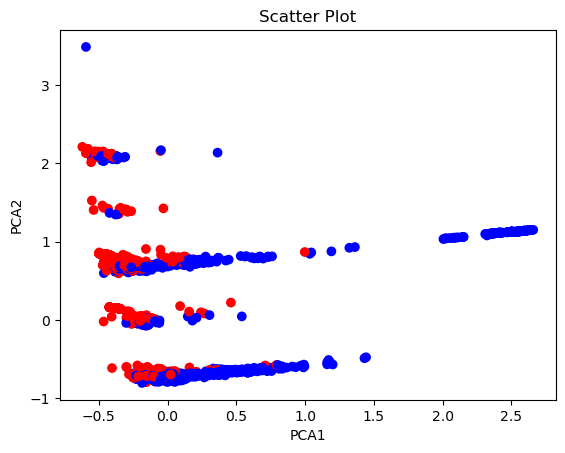

In [18]:
# Create a list of colors based on classes
colors = ['red' if i == 0 else 'blue' for i in y]

plt.scatter(X_set[:,1], X_set[:,0], color=colors, marker='o')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Scatter Plot')
plt.show()

## Splitting the dataset into the Training set and Test set

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## Training the XGBoost on the Training set

In [20]:
xgb = XGBClassifier(n_estimators=200,max_depth=7,learning_rate=0.5,gamma=0.4)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Predicting the Test set results

In [21]:
y_hat = xgb.predict(X_test)
y_hat = (y_hat > 0.5)

## Making the Confusion Matrix

In [22]:
cm = confusion_matrix(y_test, y_hat)
print(cm)
accuracy_score(y_test, y_hat)

[[592  61]
 [ 39 613]]


0.9233716475095786

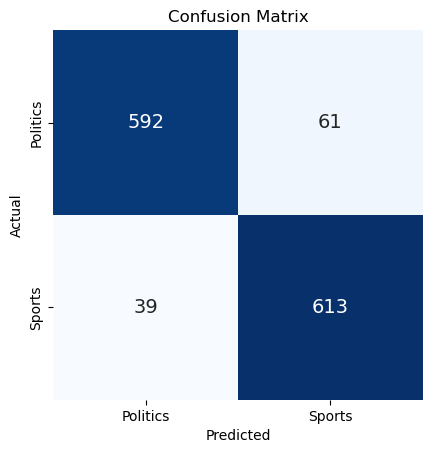

In [23]:
# Create a heatmap of the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
            annot_kws={"size": 14}, square=True, xticklabels=["Politics", "Sports"],
            yticklabels=["Politics", "Sports"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Grid Search for Hyper-parameter tuning

In [24]:
# Define the grid of hyperparameters to search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0,4, 0,5],
    'n_estimators': [100, 200, 300],
    'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],

}

In [25]:
# Define the grid of hyperparameters to search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0,4, 0,5],
    'n_estimators': [100, 200, 300],
    'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],

}

In [26]:
# Perform grid search using cross-validation
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy', 
    cv=5,
    n_jobs = -1
)

In [36]:
# Fit the grid search to the data
#grid_search.fit(X_train, y_train)

In [28]:
# Print the best hyperparameters and corresponding accuracy score
#print("Best Hyperparameters:", grid_search.best_params_)
#print("Best Accuracy Score:", grid_search.best_score_)

In [29]:
# Predict using the best model
#best_model = grid_search.best_estimator_

In [30]:
#y_hat = best_model.predict(X_test)
#y_hat = (y_hat > 0.5)

In [31]:
#cm = confusion_matrix(y_test, y_hat)
#print(cm)
#accuracy_score(y_test, y_hat)

## Applying k-Fold Cross Validation

In [33]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = 5)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 91.46 %
Standard Deviation: 0.89 %


## Submit The test file

In [34]:
y_pred = xgb.predict(X_testing)
y_pred = (y_pred > 0.5)
lables={1:'Sports' ,0:'Politics'}
y_pred=[lables[i] for i in y_pred]

In [35]:
df = pd.DataFrame({'TweetId': test['TweetId'], 'Label': y_pred})
df.to_csv('submission.csv', index=False)